In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import LinAlgError
from scipy.stats import skew, kurtosis
from PIL import Image
import sys, os
import logging
import argparse, copy
import time
import sutils
import steerable_pyramid_mat as steerable
import texture_analysis_g as ta
import scipy.io
from pandas import DataFrame as df
logger = logging.getLogger()
logger.setLevel(level=50)

# memo

- parents 達はなぜ2倍位相にするのか これは学びたい

In [2]:
class my_arg:
    def __init__(self):
        self.orig_img = "periodic/CountExamp1.o.jpg"
        self.out_dir = "tmp"
        self.num_depth = 4
        self.num_ori = 4
        self.num_neighbor = 7
        self.iter = 100
args = my_arg()

arg = my_arg()
iter = arg.iter
orig_img = arg.orig_img
out_dir  = arg.out_dir
num_depth= arg.num_depth
num_ori  = arg.num_ori
num_neighbor = arg.num_neighbor

im = np.array(Image.open(args.orig_img).convert("L"))

resol_x = im.shape[1]
resol_y = im.shape[0]

__file__ = "aa"
LOG_FMT = "[%(name)s] %(asctime)s %(levelname)s %(lineno)s %(message)s"
logging.basicConfig(level=logging.DEBUG, format=LOG_FMT)
LOGGER = logging.getLogger(os.path.basename(__file__))

In [3]:
mat_data = scipy.io.loadmat("matlab/counter_not_noise.mat")

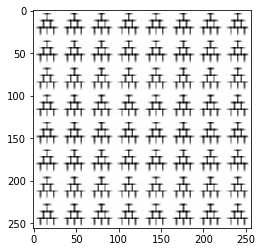

In [4]:
plt.imshow(mat_data["im0"],"gray")

In [5]:
params = mat_data["params"]
params = params[0][0]

In [6]:
orig_data = ta.TextureAnalysis(im, resol_x, resol_y, arg.num_depth, arg.num_ori, arg.num_neighbor)
orig_data.analyse()

/home/yusuke/Desktop/Steerable-pyramid/sutils.py:751: RuntimeWarning: invalid value encountered in double_scalars
  _skew = np.mean(np.mean( (image -_mean)**3 ))/_var**(3/2)
/home/yusuke/Desktop/Steerable-pyramid/sutils.py:752: RuntimeWarning: invalid value encountered in double_scalars
  _kurt = np.mean(np.mean( (image -_mean)**4 ))/_var**(2)


In [7]:
N = 4
K = 4
M = 7

In [8]:
params.dtype

dtype([('pixelStats', 'O'), ('pixelLPStats', 'O'), ('autoCorrReal', 'O'), ('autoCorrMag', 'O'), ('magMeans', 'O'), ('cousinMagCorr', 'O'), ('parentMagCorr', 'O'), ('cousinRealCorr', 'O'), ('parentRealCorr', 'O'), ('varianceHPR', 'O')])

In [9]:
param_count = np.zeros([10])

# 0. pixelStats IM_MAR
$6$

 元画像のmean,variance,skew,kurtosis,minimum,maximum 
 
- 等しい
- 互いに6次元

In [10]:
param_count[0] = 6

In [11]:
df(params[0])

,0,1,2,3,4,5
0,222.196289,3525.883435,-1.878269,5.57467,0.0,255.0


In [12]:
df(orig_data.IM_MAR).T

,0,1,2,3,4,5
0,222.196289,3525.883435,-1.878269,5.57467,255.0,0.0


# 1 pixelLPStats LR_MARとCF_MAR

$2(N+1)$

- 部分的に再構成されたローパス画像の歪度と尖度
- params[N+1][2]
- CF_MAR[N][2:4] + LR_MAR[2:4]

In [13]:
param_count[1] = 2 * (N+1)

In [14]:
df(params[1]).T

,0,1,2,3,4
0,-1.788675,-1.183097,-0.588446,-0.378953,0.0
1,5.196226,3.371317,1.852543,2.621126,3.0


In [15]:
df(np.array(orig_data.CF_MAR)[:,2:4]).T

,0,1,2,3
0,-1.788634,-1.182989,-0.588230,-0.378398
1,5.196068,3.370905,1.851638,2.616009


In [16]:
orig_data.LR_MAR[2:4]

[0, 3]

# 2 autoCorrReal  CF_CA and LR_CA
$(N+1) * \frac{(M^2+1)}{2}$

各スケールで部分的に再構成されたローパス画像の自己相関のM*M

- params[2] = [M,M,N+1] 
- CF_CF[N,M,M] + LR_CA[M,M]

In [17]:
param_count[2] = (N+1) * (M**2 + 1)/2

In [18]:
print(params[2].shape)

(7, 7, 5)


In [20]:
df(params[2][:,:,1]) # 4 = LR_CA

,0,1,2,3,4,5,6
0,4584.098019,9805.966829,10696.654354,9888.208358,10558.051801,9741.541201,4593.424974
1,-2055.616641,-413.500116,5311.397562,9072.341752,5178.161936,-443.741356,-2010.024767
2,6740.530253,7164.581075,19070.410505,27798.555635,18986.860701,7155.636787,6777.708809
3,15496.422437,16241.692582,31289.415838,42327.074100,31289.415838,16241.692582,15496.422437
4,6777.708809,7155.636787,18986.860701,27798.555635,19070.410505,7164.581075,6740.530253
5,-2010.024767,-443.741356,5178.161936,9072.341752,5311.397562,-413.500116,-2055.616641
6,4593.424974,9741.541201,10558.051801,9888.208358,10696.654354,9805.966829,4584.098019


In [21]:
df(orig_data.CF_CA[1])

,0,1,2,3,4,5,6
0,4584.098019,9805.966829,10696.654354,9888.208358,10558.051801,9741.541201,4593.424974
1,-2055.616641,-413.500116,5311.397562,9072.341752,5178.161936,-443.741356,-2010.024767
2,6740.530253,7164.581075,19070.410505,27798.555635,18986.860701,7155.636787,6777.708809
3,15496.422437,16241.692582,31289.415838,42327.074100,31289.415838,16241.692582,15496.422437
4,6777.708809,7155.636787,18986.860701,27798.555635,19070.410505,7164.581075,6740.530253
5,-2010.024767,-443.741356,5178.161936,9072.341752,5311.397562,-413.500116,-2055.616641
6,4593.424974,9741.541201,10558.051801,9888.208358,10696.654354,9805.966829,4584.098019


In [41]:
df(orig_data.LR_CA)

,0,1,2,3,4,5,6
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
a = copy.copy(orig_data.LR["s"])

In [23]:
a = a - a.mean()

In [24]:
np.dot(a.flatten(),a.flatten())/256

6.309180055109966

# 3.autoCorrMag  BND_MCOR

$N*K*\frac{M^2 + 1}{2}$

- 各サブバンドの画像の絶対値の自己相関の中央サンプルM*M
- pythonとちがう
- params[3] = [M,M,N,K]
- BND_MCOR[N,K,M,M]

In [22]:
param_count[3] =  N * K * (M**2 + 1)/2

In [23]:
params[3].shape

(7, 7, 4, 4)

In [24]:
df(params[3][:,:,0,3])

,0,1,2,3,4,5,6
0,32.275510,46.987519,55.479584,48.350316,45.058760,52.647792,54.017337
1,44.306377,54.969662,49.968426,49.786908,62.913680,67.311390,49.744653
2,51.482141,48.583728,50.652037,69.022746,78.797208,60.371556,40.788573
3,44.255469,47.265978,67.947749,83.593219,67.947749,47.265978,44.255469
4,40.788573,60.371556,78.797208,69.022746,50.652037,48.583728,51.482141
5,49.744653,67.311390,62.913680,49.786908,49.968426,54.969662,44.306377
6,54.017337,52.647792,45.058760,48.350316,55.479584,46.987519,32.275510


In [25]:
df(orig_data.BND_MCOR[0][3])

,0,1,2,3,4,5,6
0,32.275510,46.987519,55.479584,48.350316,45.058760,52.647792,54.017337
1,44.306377,54.969662,49.968426,49.786908,62.913680,67.311390,49.744653
2,51.482141,48.583728,50.652037,69.022746,78.797208,60.371556,40.788573
3,44.255469,47.265978,67.947749,83.593219,67.947749,47.265978,44.255469
4,40.788573,60.371556,78.797208,69.022746,50.652037,48.583728,51.482141
5,49.744653,67.311390,62.913680,49.786908,49.968426,54.969662,44.306377
6,54.017337,52.647792,45.058760,48.350316,55.479584,46.987519,32.275510


# 4.magMeans BND_MMAR

$N*K$

- 各スケール，各サブバンドにおける絶対値の平均値
- 絶対値がらみはpythonと違うっぽい

- params[4] = [18,1] L0 と H0が含まれているため

- BND_MMAR[N,K][6] [0]を抜き出すことになる 

In [26]:
param_count[4] = N * K

In [27]:
params[4].shape #H0 とL0 が含まれているため． 16 + 2

(18, 1)

In [28]:
df(params[4].reshape(1,-1))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,4.441547,15.905799,10.578581,17.216618,10.508453,75.208884,70.013402,99.545267,70.082209,205.71842,201.275729,190.67966,202.396425,1939.865756,900.668615,1499.93915,901.678233,2.08845


In [29]:
df(np.array(orig_data.BND_MMAR)[:,:,0].flatten()).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,15.906233,10.579872,17.21807,10.507984,75.204111,70.014702,99.547857,70.076099,205.686098,201.25349,190.681158,202.378537,1940.051298,900.693287,1499.853544,901.720137


In [30]:
params[4].reshape(-1)[1:17] - np.array(orig_data.BND_MMAR)[:,:,0].flatten()

array([-0.00043483, -0.00129133, -0.00145182,  0.00046858,  0.00477368,
       -0.00130001, -0.00259035,  0.00610971,  0.03232194,  0.02223933,
       -0.00149835,  0.01788783, -0.18554232, -0.02467171,  0.08560562,
       -0.04190452])

# 5.Cousin mag corr  　 CF_COUS
$ N * \frac{K*(K-1)}{2}$

各スケールにおける，各サブバンド対の絶対値の相互相関

- params[5] = [K,K,(N+1)]
  - params[5][:,:,4] は0であることに注意
  
- CF_COUS[N,K,K]
- 値はpythonのものとやっぱり違いそう

- CF_COUS[]

In [31]:
param_count[5] = N*(K*(K-1))/2

In [32]:
params[5].shape

(4, 4, 5)

In [33]:
df(params[5][:,:,0])

,0,1,2,3
0,291.117209,113.467555,155.254183,114.881275
1,113.467555,82.846866,113.168786,62.175825
2,155.254183,113.168786,256.844282,114.395316
3,114.881275,62.175825,114.395316,83.568361


In [34]:
df(orig_data.CF_COUS[0])

,0,1,2,3
0,291.165550,113.459582,155.302286,114.900339
1,113.459582,82.847972,113.173108,62.180119
2,155.302286,113.173108,256.910993,114.438342
3,114.900339,62.180119,114.438342,83.590008


# 6 Parent mag corr CF_CPAR 
$ K^2 (N-1)$

各スケールのサブバンドとより粗いスケールのサブバンドの絶対値の相互相関 

- params[6] = [4,4,4]
  - params[6][:,:,3] は0であることに注意する．
  
- CF_CPAR[N-1,K,K]


In [35]:
param_count[6] = K*K*(N-1)

In [36]:
print(params[6].shape)

(4, 4, 4)


In [37]:
params[6][:,:,2] 

array([[ -255.28144269,  -693.78201858,   365.79206368,  -667.8428384 ],
       [ -917.39776878,   366.49453824,   685.1201131 , -3839.98288069],
       [ -415.30316037,   438.92788783,  1858.95282783,   385.9191696 ],
       [ -933.5019696 , -3807.6488457 ,   799.50019379,   398.07434534]])

In [38]:
orig_data.CF_CPAR

[array([[230.70083511, 132.16035401, 250.59052016, 133.45592728],
        [ 88.96197028,  85.98739825, 152.93817847,  85.05082173],
        [108.08851437, 177.99297034, 317.24137977, 180.91347048],
        [ 88.29622213,  84.95075898, 154.34568223,  88.251971  ]]),
 array([[280.29208337, 297.53961191, 870.11345031, 295.40499494],
        [167.20918315,  54.66687291, 595.38588251, 279.10181324],
        [284.54087715, 178.670249  , 560.20454763, 204.51434772],
        [168.64018281, 262.13137005, 608.92823211,  60.3735673 ]]),
 array([[ -255.07403523,  -692.70291998,   365.70851581,  -667.12679867],
        [ -917.58928117,   365.37916821,   686.56669263, -3837.68292394],
        [ -414.30287642,   439.7361832 ,  1861.01819503,   390.94490129],
        [ -935.29717414, -3809.04921294,   798.60824019,   394.53177439]])]

# 7 Cousin real corr CF_RCOU
$ N \frac{K(K-1)}{2}$

各スケールにおける，各サブバンド対の実数の相互相関

- params[7] = [8,8,5]
  - 8 * 8の行列であるが，4 * 4しか使っていないことに注意
  - 配列が5個あるのが謎である．．最下層のスケールにバンドでもあんの？？
 
- CF_RCOU[N,K,K]

In [39]:
param_count[7] = N*(K*(K-1))/2

In [40]:
params[7].shape

(8, 8, 5)

In [41]:
df(params[7][:,:,1])

,0,1,2,3,4,5,6,7
0,5111.983025,2670.657303,-1.939498,-2702.313037,0.0,0.0,0.0,0.0
1,2670.657303,4068.576957,3534.276685,600.852429,0.0,0.0,0.0,0.0
2,-1.939498,3534.276685,8714.274680,3534.153721,0.0,0.0,0.0,0.0
3,-2702.313037,600.852429,3534.153721,4098.631816,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
5,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
6,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
7,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


In [42]:
orig_data.CF_RCOU[1]

array([[ 5.11152982e+03,  2.67039184e+03, -1.91301162e+00,
        -2.70214985e+03],
       [ 2.67039184e+03,  4.06857953e+03,  3.53458426e+03,
         6.00961437e+02],
       [-1.91301162e+00,  3.53458426e+03,  8.71481467e+03,
         3.53420544e+03],
       [-2.70214985e+03,  6.00961437e+02,  3.53420544e+03,
         4.09841986e+03]])

# 8. parent real corr CF_RPAR
$2*K^2 (N-1)$

 クロススケール位相特性
 各スケールの実数成分と．1つ粗いスケールで位相を二倍した実数及び虚数との相互相関

- params[8] = [2K,2K,(N)]
 - なぜ4まであるか謎である．
 - (8*8)であるが実際は(4,8)しか使ってない．
 
- CF_RPAR[N-1,K,2K]

In [43]:
param_count[8] = 2*K*K*(N-1)

In [44]:
print(params[8].shape)

(8, 8, 4)


In [45]:
complex(0,1)

1j

In [46]:
df(params[8][:,:,0])

,0,1,2,3,4,5,6,7
0,-0.239580,-12.730059,0.033107,13.385586,-236.691207,-36.924897,0.043128,36.419007
1,1.977989,-1.386522,15.577418,7.225154,-86.343440,-54.516089,-121.436640,-0.584874
2,-0.108949,12.735916,38.681420,11.708773,-0.143356,-48.794387,-331.196847,-49.077506
3,2.123031,7.008979,14.899405,-3.046876,84.916765,-0.723033,-120.970745,-55.698447
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [47]:
df(orig_data.CF_RPAR[0])

,0,1,2,3,4,5,6,7
0,-0.279413,-12.743050,0.033114,13.382287,-236.684696,-36.918687,0.043763,36.421820
1,1.959431,-1.397172,15.590301,7.222181,-86.347459,-54.497611,-121.453854,-0.586351
2,-0.110661,12.741273,38.705585,11.697919,-0.143422,-48.794324,-331.249658,-49.093549
3,2.134928,7.012429,14.905339,-3.060979,84.908520,-0.727379,-120.991871,-55.716491


# 9.variance HPR  orig_data.H0_PRO
$1$

h0の分散．
- 一緒っぽい

In [48]:
param_count[9] = 1

In [35]:
params[9]

array([[41.85841985]])

In [36]:
orig_data.H0_PRO

41.85841984837308